<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/python/area.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Az egyszerű algoritmustól a vektorizáláson át az osztályokig

A koordinátákból területszámítás egyszerű számítási példáján keresztül mutatunk be Python programozási megoldásokat.

Egy zárt sokszög idom területét a koordinátákból az alábbi képlettel számíthatjuk ki:

$2T = \sum_1^n (x_i + x_{i+1}) (y_i - y_{i+1})$

A fenti képletben az utolsó pont esetén (i = n) az i+1 az első pontra vonatkozik. Az idom területét az egyes oldalakhoz tartozó trapézok területének összegzésével számítjuk ki. A trapéz párhuzamos oldalai az *x* tengellyel párhuzamosak, a negyedik oldal az *y* tengely.

In [86]:
import matplotlib.pyplot as plt
import numpy as np

Egy egyszerű alakzat a képlet értelmezéséhez.
Figyelem a trapézok területe a képletben előjeles szám!

Text(0.5, 1.0, 'Trapézok')

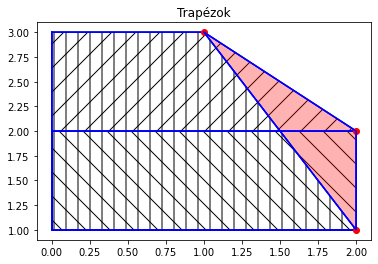

In [87]:
x = [1, 2, 2, 1]    # a kezdőpontot a lista végére is betettük
y = [3, 2, 1, 3]
# a trapézok
h = ['/', '\\', '|']
for i in range(len(x)-1):
    plt.fill([0, x[i], x[i+1], 0, 0], [y[i], y[i], y[i+1], y[i+1], y[i]], fill=False, hatch=h[i])
for i in range(len(x)-1):
    plt.plot([0, x[i], x[i+1], 0, 0], [y[i], y[i], y[i+1], y[i+1], y[i]], '-b')
plt.plot(x[:-1], y[:-1], 'ro')    # a töréspontok
plt.fill(x[:-1], y[:-1], 'r', fill=True, alpha=0.3)    # terület
plt.plot(x, y, '-b')          # az oldalak
plt.title('Trapézok')

Készítsük el az első megoldásunkat a területszámításra függvényként. A koordinátákat egy listában várja, melyben a az egyes pontok koordinátáit egy két elemű lista tartalmazza, a kezdőpontot nem kell megismételni.

In [88]:
def area1(coords):
    """ területszámítás koordinátákból """
    w = 0.0
    for i in range(len(coords)):
        j = (i + 1) % len(coords)   # maradékképzés
        w += (coords[j][0] + coords[i][0]) * (coords[j][1] - coords[i][1])
    return abs(w) /2.0

A def alapszó jelöli a függvény kezdetét, utána a függvény neve és zárójelben a paraméterei következnek. A return után álló kifejezés értékét adja vissza a függvény.

Próbáljuk ki a függvényünket!

In [89]:
coords = [[634110.62, 232422.09],
          [634108.23, 232365.96],
          [634066.13, 232378.12],
          [634062.95, 232457.58],
          [634111.68, 232454.93]]
print(area1(coords))

3835.1187999993563


A hatékonyság érdekében általában célszerű a ciklusokat elkerülni. Ezt vektorizálásnak nevezzük, a ciklusok helyett mátrix műveleteket hajtunk végre. Ehhez a numpy modul segíthet. Írjuk át a függvényünket.

In [90]:
def area2(coo):
    """ területszámítás kordinátákból, vektorizált változat """
    return abs(np.sum(np.multiply(np.add(coo[1:, 0], coo[:-1, 0]), np.diff(coo[:, 1])) / 2))

Próbáljuk ki ezt a függvényt is!

In [91]:
coords1 = coords.copy()
if coords1[-1] != coords1[0]:
        coords1.append(coords[0])     # kezdőpont megismétlése a lista végén
crds = np.array(coords1)  # átalakítás numpy tömbbé

print(area2(crds))

3835.1187999993563



Hasonlítsuk össze a két megoldást (ciklus és vektorizált), ehhez a *timeit* modult használjuk. 

In [104]:
from timeit import timeit
print(coords)
print(area1(coords))
print(crds)
print(area2(crds))
print(timeit('area1(coords1)', globals=globals(), number=100_000))
print(timeit('area2(crds)', globals=globals(), number=100_000))

[[634110.62, 232422.09], [634108.23, 232365.96], [634066.13, 232378.12], [634062.95, 232457.58], [634111.68, 232454.93]]
3835.1187999993563
[[634110.62 232422.09]
 [634108.23 232365.96]
 [634066.13 232378.12]
 [634062.95 232457.58]
 [634111.68 232454.93]
 [634110.62 232422.09]]
3835.1187999993563
0.28154469299988705
1.3335601599974325


A várakozásainkkal ellentétben az első megoldás a gyorsabb.

Nézzük meg sok pontból álló sokszögre is.

In [106]:
# kör kerületén lévő pontokat generálunk
from math import pi, sin, cos

def poly_gen(r, n):
    c = []
    for i in range(n):
        a = i * 2 * pi / n
        x = r * cos(a)
        y = r * sin(a)
        c.append([x, y])
    return c

coords2 = poly_gen(500, 100)
coords3 = np.array(coords2)
print(area1(coords2))
print(area2(coords3))
print(timeit('area1(coords2)', globals=globals(), number=10_000))
print(timeit('area2(coords3)', globals=globals(), number=10_000))


784881.4941164174
769199.3520774839
0.39524575599716627
0.17022966900185565


Több töréspont esetén már a vektorizált megoldás a gyorsabb, de vegyük észre azt is, hogy az eredmények között is eltérés van a kerekítési hibák miatt.